**Кейс "Алгоритмический трейдинг"**


Абдрахманова Нелли Тагировна

МГУ, мехмат, 5 курс


Установка и импорт нужных библиотек.

In [ ]:
pip install arch 

In [ ]:
pip install yfinance # для выгрузки данных об акциях

In [ ]:
pip install ffn

In [4]:
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
import matplotlib.pyplot as plt

import yfinance as yf
from arch import arch_model 

Стратегия - **alpha momentum**. Alpha - остаток между доходностью акций и суммой всех факторов, влияющих на эту доходность. Например, рынок, стоимость, размер, импульс, низкая волатильность, качество, рост и дивидендная доходность. 

В кейсе будут использоваться акции компании Amazon.

В качестве фактора, влияющего на alpha возьмём только рынок - индекс ETF QQQ, так как в нём доминируют крупные технологические компании (Apple, Amazon, Google, Facebook).

**Выгрузка** **данных**

[*********************100%***********************]  1 of 1 completed


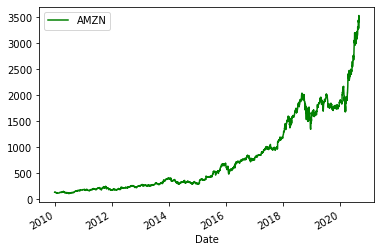

In [5]:
data = yf.download('AMZN','2009-12-31','2020-09-05')
data['Adj Close'].plot(color = 'green')
plt.legend(['AMZN'])
plt.show()
# график цен AMZN

In [6]:
data.index = data.index.to_period(freq='d')

[*********************100%***********************]  1 of 1 completed


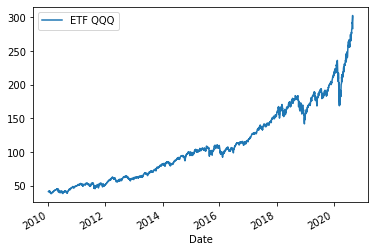

In [7]:
qqq = yf.download('QQQ','2009-12-31','2020-09-05')
qqq['Adj Close'].plot()
plt.legend(['ETF QQQ'])
plt.show()
# график цен QQQ

In [8]:
qqq.index = qqq.index.to_period(freq='d')

In [9]:
price = data['Adj Close']
price.head()

Date
2009-12-31    134.520004
2010-01-04    133.899994
2010-01-05    134.690002
2010-01-06    132.250000
2010-01-07    130.000000
Freq: D, Name: Adj Close, dtype: float64

In [10]:
price_qqq = qqq['Adj Close']
price_qqq.head()

Date
2009-12-31    41.045174
2010-01-04    41.646263
2010-01-05    41.646263
2010-01-06    41.395069
2010-01-07    41.421986
Freq: D, Name: Adj Close, dtype: float64

**Доходности**

Переход к доходностям акций AMZN и индекса ETF QQQ.

In [11]:
ret = price.pct_change()
ret = ret.dropna()

In [12]:
ret_qqq = price_qqq.pct_change()
ret_qqq = ret_qqq.dropna()

Доходности AMZN на графике:

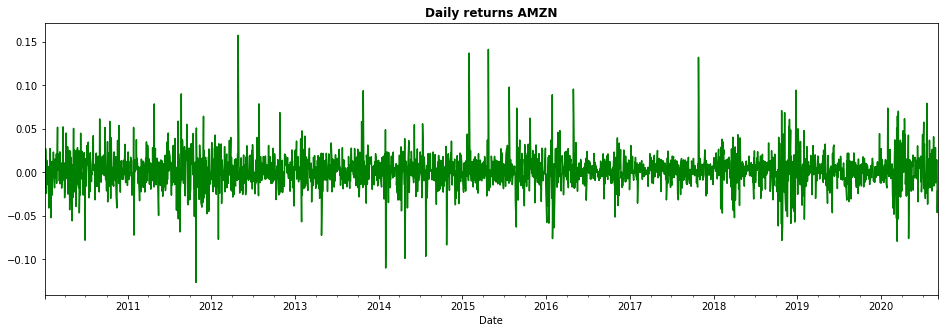

In [13]:
fig = plt.figure(figsize=(16, 5))

ret.plot(color = 'green')
plt.title("Daily returns AMZN", weight="bold")

plt.show()

Распределение доходностей AMZN:

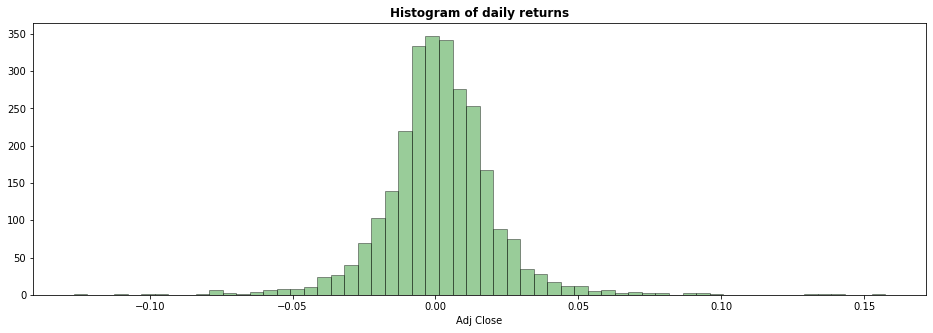

In [14]:
fig = plt.figure(figsize=(16, 5))

sns.distplot(ret, hist=True, kde=False, 
             bins=60,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4}, color='green')

plt.title("Histogram of daily returns", weight="bold")

plt.show()

Alpha - как разность доходностей акций AMZN и доходностей рынка (ETF QQQ).

In [15]:
alpha = pd.Series(index = ret.index)
for i in range(0, len(ret)):
  alpha[i] = ret[i] - ret_qqq[i]

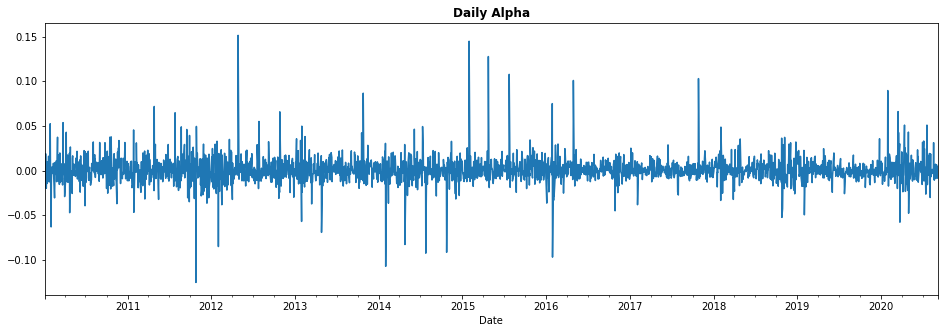

In [16]:
fig = plt.figure(figsize=(16, 5))

alpha.plot()
plt.title("Daily Alpha", weight="bold")

plt.show()

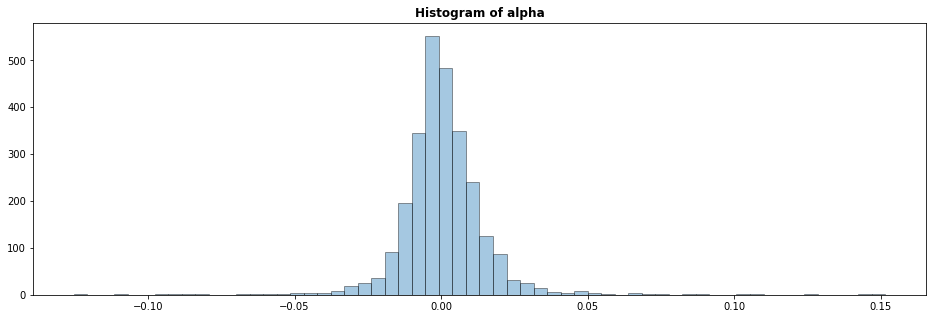

In [17]:
fig = plt.figure(figsize=(16, 5))

sns.distplot(alpha, hist=True, kde=False, 
             bins=60,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

plt.title("Histogram of alpha", weight="bold")

plt.show()

**Фильтрация**

Когда мы делаем фильтрацию мы пытаемся избавиться от "влияния внешних факторов", но при alpha momentum мы учитываем внешние факторы (только те, которые нас интересуют и могут влиять по нашим предположениям), поэтому отфильтруем alpha. Получим стандартизированные остатки.

Окно = 250 дней.

Модель: AR + GARCH.

Распределение Стьюдента.

In [18]:
window = 250
sigma_t = pd.Series([np.nan]*len(alpha), index = alpha.index)
mean_t = pd.Series([np.nan]*len(alpha), index = alpha.index)
st_res_t = pd.Series([np.nan]*len(alpha), index = alpha.index)
for i in range(window, len(alpha)):
  history = alpha[i - window:i]
  mdl = arch_model(100*history,
                    mean='AR', lags=1, # mean = Constant, ARX, HARX + the number of lags
                    vol='GARCH', p=1, o=1, q=1, # vol = Garch, EGARCH, HARCH + the number of lags
                    dist='t') # dist = Normal, t, skewstudent, ged
  res = mdl.fit()
  sigma_t[i] = np.sqrt(res.forecast(horizon = 1).variance.tail(1)['h.1'][0])
  mean_t[i] = res.forecast(horizon = 1).mean.tail(1)['h.1'][0]
  st_res_t[i] = (alpha[i]*100 - mean_t[i]) / sigma_t[i]

Streaming output truncated to the last 5000 lines.
Iteration:     15,   Func. Count:    151,   Neg. LLF: 276.6462546695608
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 276.6462539507281
            Iterations: 15
            Function evaluations: 152
            Gradient evaluations: 15
Iteration:      1,   Func. Count:      9,   Neg. LLF: 282.32637757876677
Iteration:      2,   Func. Count:     21,   Neg. LLF: 280.24418606501854
Iteration:      3,   Func. Count:     32,   Neg. LLF: 279.4477213753729
Iteration:      4,   Func. Count:     44,   Neg. LLF: 279.4000565037237
Iteration:      5,   Func. Count:     54,   Neg. LLF: 278.89754614704356
Iteration:      6,   Func. Count:     64,   Neg. LLF: 277.683038058207
Iteration:      7,   Func. Count:     74,   Neg. LLF: 277.32490438728695
Iteration:      8,   Func. Count:     84,   Neg. LLF: 277.14911894550823
Iteration:      9,   Func. Count:     94,   Neg. LLF: 276.8726922486253
Iteration:    

In [19]:
st_res_t = st_res_t / 100 # поделим на 100, так как до этого умножали на 100 для алгоритма

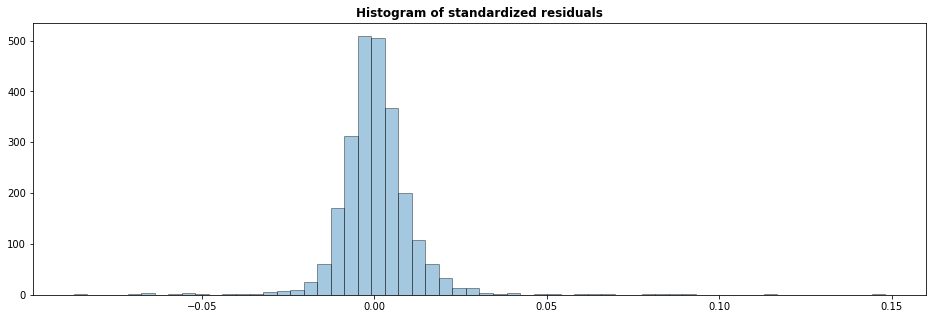

In [20]:
fig = plt.figure(figsize=(16, 5))

sns.distplot(st_res_t, hist=True, kde=False, 
             bins=60,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

plt.title("Histogram of standardized residuals", weight="bold")

plt.show()

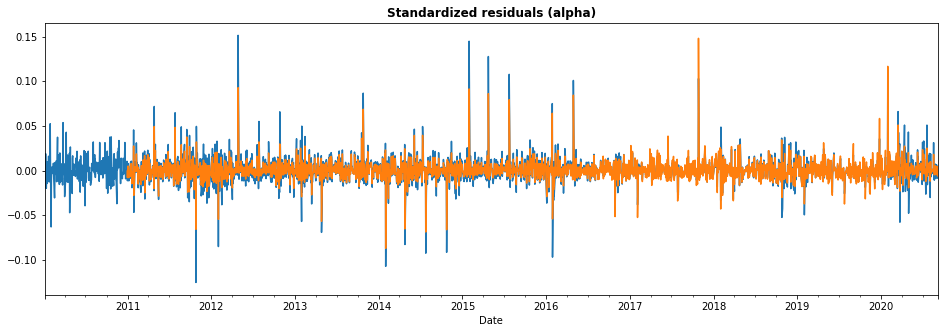

In [21]:
fig = plt.figure(figsize=(16, 5))
alpha.plot()
st_res_t.plot()
plt.title("Standardized residuals (alpha)", weight="bold")

plt.show()

Удалим NaN (получились из-за окошка 250 дней).

In [22]:
st_res_t = st_res_t.dropna()

In [23]:
st_res_t += 1 

In [24]:
price_new = price[251:]

In [25]:
train_st_res_t = st_res_t['2010-01-01':'2018-12-31']
train_prices = price_new['2010-01-01':'2018-12-31']

In [26]:
train_st_res_t.index = train_st_res_t.index.to_timestamp()

In [27]:
mean_st_res_t = train_st_res_t.resample('M').last()

In [28]:
money = 1000000.0
portf = pd.Series([money]*len(train_st_res_t), index = train_st_res_t.index, dtype="float")
tran_cost = 0.001
w = 11
numb_stocks = 0

In [29]:
def month_ago(t, n, kol):
  p = 1
  for i in range(n - kol, n):
    p *= t[i]
  return p

In [30]:
j = 0
k = w
for i in range (482, len(train_st_res_t)):
  j += 1
  if (j <= 21):
    month_w = month_ago(mean_st_res_t, k, w)
  else:
    j = 0
    k += 1
  if month_w >= 1:
    if numb_stocks == 0:
      numb_stocks = round((money * 0.05) / train_prices[i])
      money -= numb_stocks * train_prices[i] * (1 + tran_cost)
  else:
    if numb_stocks > 0: 
      money += numb_stocks * train_prices[i] * (1 - tran_cost)
      numb_stocks = 0
  portf[i] = money + numb_stocks * train_prices[i]
  print(i, portf[i], month_w, numb_stocks)

482 1000000.0 0.9734121073697116 0
483 1000000.0 0.9734121073697116 0
484 1000000.0 0.9734121073697116 0
485 1000000.0 0.9734121073697116 0
486 1000000.0 0.9734121073697116 0
487 1000000.0 0.9734121073697116 0
488 1000000.0 0.9734121073697116 0
489 1000000.0 0.9734121073697116 0
490 1000000.0 0.9734121073697116 0
491 1000000.0 0.9734121073697116 0
492 1000000.0 0.9734121073697116 0
493 1000000.0 0.9734121073697116 0
494 1000000.0 0.9734121073697116 0
495 1000000.0 0.9734121073697116 0
496 1000000.0 0.9734121073697116 0
497 1000000.0 0.9734121073697116 0
498 1000000.0 0.9734121073697116 0
499 1000000.0 0.9734121073697116 0
500 1000000.0 0.9734121073697116 0
501 1000000.0 0.9734121073697116 0
502 1000000.0 0.9734121073697116 0
503 1000000.0 0.9734121073697116 0
504 1000000.0 0.9736454879060392 0
505 1000000.0 0.9736454879060392 0
506 1000000.0 0.9736454879060392 0
507 1000000.0 0.9736454879060392 0
508 1000000.0 0.9736454879060392 0
509 1000000.0 0.9736454879060392 0
510 1000000.0 0.9736

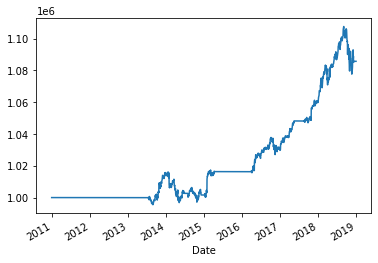

In [31]:
portf.plot()

In [32]:
portf[len(portf) - 1] - portf[0]

85722.490054016

In [33]:
import ffn
portf.calc_stats().display()

Stats for None from 2010-12-30 00:00:00 - 2018-12-31 00:00:00
Annual risk-free rate considered: 0.00%
Summary:
Total Return      Sharpe  CAGR    Max Drawdown
--------------  --------  ------  --------------
8.57%               0.77  1.03%   -2.70%

Annualized Returns:
mtd     3m      6m      ytd    1y     3y     5y     10y    incep.
------  ------  ------  -----  -----  -----  -----  -----  --------
-0.25%  -1.80%  -0.29%  2.45%  2.45%  2.23%  1.36%  1.03%  1.03%

Periodic:
        daily    monthly    yearly
------  -------  ---------  --------
sharpe  0.77     0.75       0.75
mean    1.04%    1.04%      1.04%
vol     1.35%    1.38%      1.39%
skew    -0.17    -0.70      -0.39
kurt    19.33    8.86       -0.47
best    0.72%    1.46%      2.92%
worst   -0.71%   -2.01%     -1.30%

Drawdowns:
max     avg       # days
------  ------  --------
-2.70%  -0.24%     25.41

Misc:
---------------  ------
avg. up month    0.46%
avg. down month  -0.11%
up year %        62.50%
12m up %         67.44

**Валидационная выборка**

In [34]:
valid_st_res_t = st_res_t['2018-02-01':'2019-12-31']
valid_prices = price_new['2019-01-01':'2019-12-31']

In [35]:
valid_st_res_t.index = valid_st_res_t.index.to_timestamp()

In [36]:
mean_valid_month = valid_st_res_t.resample('M').last()

In [37]:
valid_st_res_t = st_res_t['2019-01-01':'2019-12-31']

In [38]:
money = 1000000.0
portf_val = pd.Series([money]*len(valid_st_res_t), index = valid_st_res_t.index, dtype="float")
tran_cost = 0.001
w = 11
numb_stocks = 0

In [39]:
j = 0
k = w
for i in range(0, len(valid_st_res_t)):
  j += 1
  if (j <= 21):
    month_w = month_ago(mean_valid_month, k, w)
  else:
    j = 0
    k += 1
  if month_w >= 1:
    if numb_stocks == 0:
      numb_stocks = round((money * 0.05) / valid_prices[i])
      money -= numb_stocks * valid_prices[i] * (1 + tran_cost)
  else:
    if numb_stocks > 0: 
      money += numb_stocks * valid_prices[i] * (1 - tran_cost)
      numb_stocks = 0
  portf_val[i] = money + numb_stocks * valid_prices[i]

In [40]:
portf_val[len(valid_st_res_t) - 1] - portf_val[0]

10326.599882812472

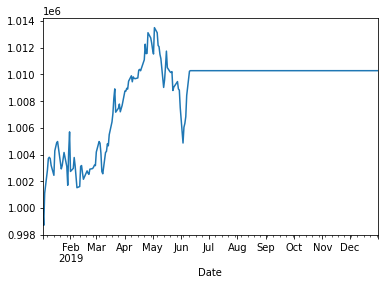

In [41]:
portf_val.plot()

In [42]:
portf_val.index = portf_val.index.to_timestamp()

In [43]:
portf_val.calc_stats().display()

Stats for None from 2019-01-02 00:00:00 - 2019-12-31 00:00:00
Annual risk-free rate considered: 0.00%
Summary:
Total Return      Sharpe  CAGR    Max Drawdown
--------------  --------  ------  --------------
1.03%               1.03  1.04%   -0.85%

Annualized Returns:
mtd    3m     6m     ytd    1y    3y    5y    10y    incep.
-----  -----  -----  -----  ----  ----  ----  -----  --------
0.00%  0.00%  0.00%  1.03%  -     -     -     -      1.04%

Periodic:
        daily    monthly    yearly
------  -------  ---------  --------
sharpe  1.03     0.52       -
mean    1.04%    0.50%      -
vol     1.01%    0.96%      -
skew    -0.19    -0.06      -
kurt    5.90     0.30       -
best    0.24%    0.46%      -
worst   -0.29%   -0.48%     -

Drawdowns:
max     avg       # days
------  ------  --------
-0.85%  -0.21%     29.91

Misc:
---------------  ------
avg. up month    0.40%
avg. down month  -0.09%
up year %        -
12m up %         -
---------------  ------


Бетта с рынком (S&P500) для валидационной выборки.

In [44]:
from scipy import stats

In [45]:
benchmark_price = yf.download('^GSPC', '2018-12-30', '2020-01-01')
                               
benchmark_ret = benchmark_price["Adj Close"].pct_change()

[*********************100%***********************]  1 of 1 completed


In [46]:
benchmark_ret = benchmark_ret.dropna()

In [47]:
benchmark_ret

Date
2019-01-02    0.001268
2019-01-03   -0.024757
2019-01-04    0.034336
2019-01-07    0.007010
2019-01-08    0.009695
                ...   
2019-12-24   -0.000195
2019-12-26    0.005128
2019-12-27    0.000034
2019-12-30   -0.005781
2019-12-31    0.002946
Name: Adj Close, Length: 252, dtype: float64

In [48]:
x = np.array(benchmark_ret[1:])
y = np.array(portf_val.pct_change()[1:])

In [49]:
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
print("slope: %f    intercept: %f" % (slope, intercept))

slope: 0.040917    intercept: -0.000001


Максимальная просадка для валидационной выборки.

In [50]:
Max_week = portf_val['2019-01-02':].resample('W').max()
Min_week = portf_val['2019-01-02':].resample('W').min()
Max_drowdans_week =((Min_week - Max_week) / Max_week).min()
print(Max_drowdans_week)

-0.003972563760754334


**VaR**

In [51]:
money = 1000000.0
portf_v = pd.Series([money]*len(alpha[:'2020-01-01']), index = alpha[:'2020-01-01'].index, dtype="float")
tran_cost = 0.001
w = 11
numb_stocks = 0

In [52]:
mean_st_res = st_res_t.resample('M').last()

In [53]:
j = 0
k = w
for i in range (482, len(alpha[:'2020-01-01'])):
  j += 1
  if (j <= 21):
    month_w = month_ago(mean_st_res, k, w)
  else:
    j = 0
    k += 1
  if month_w >= 1:
    if numb_stocks == 0:
      numb_stocks = round((money * 0.05) / price[i])
      money -= numb_stocks * price[i] * (1 + tran_cost)
  else:
    if numb_stocks > 0: 
      money += numb_stocks * price[i] * (1 - tran_cost)
      numb_stocks = 0
  portf_v[i] = money + numb_stocks * price[i]

In [54]:
res_ = portf_v.pct_change()[1:]

In [55]:
#res_[900:987], res_[1010:1076],res_[1318:1604], 

In [56]:
res_new = pd.concat([res_[900:987], res_[1010:1076],res_[1318:1604], res_[1671:2000], res_[2351:2484], res_[2659:]]) #выкидываем промежутки, где не было торговли

In [57]:
def calculate_VaR_garch(returns, alpha):
    
    scaling_const = 10.0 / returns.std()

    dist = 't'
    am = arch_model(scaling_const * returns,
                    mean='ARX', lags=1, # mean = Constant, ARX, HARX + the number of lags
                    vol='Garch', p=1, o=1, q=1, # vol = Garch, EGARCH, HARCH + the number of lags
                    dist=dist) # dist = Normal, t, skewstudent, ged

    res = am.fit(update_freq=0, disp='off')

    forecasts = res.forecast(horizon=1)

    cond_mean = float(forecasts.mean.iloc[-1])
    cond_var = float(forecasts.variance.iloc[-1])

    if dist == 'Normal':
        q = am.distribution.ppf(alpha)
    elif dist == 't' or dist == 'ged':
        q = am.distribution.ppf(alpha, res.params[-1:])
    elif dist == 'skewstudent':
        q = am.distribution.ppf(alpha, res.params[-2:])

    return_garch_forecast = cond_mean / scaling_const
    VaR_garch_forecast = (cond_mean + np.sqrt(cond_var) * q) / scaling_const

    return VaR_garch_forecast

    
def calc_VaR(r, VaR_fun, L_history=250, level=0.05):
    VaR = np.full(r.size, np.nan)
    
    for i in range(L_history, len(r)):
        history = r[i - L_history: i]
        VaR[i] = VaR_fun(history, level)
        
    return pd.Series(data=VaR, index=r.index, name=VaR_fun.__name__)


VaR_garch = calc_VaR(res_new, calculate_VaR_garch, L_history=250, level=0.05)

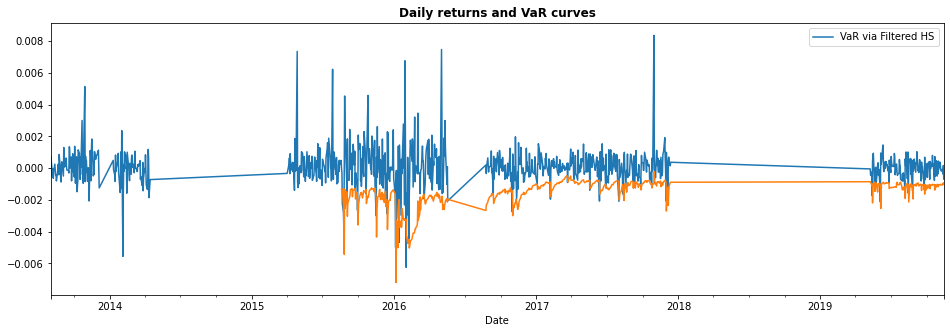

In [58]:
fig = plt.figure(figsize=(16, 5))
res_new.plot()

VaR_garch.plot()

plt.title("Daily returns and VaR curves", weight="bold")

plt.legend(['VaR via Filtered HS'])

plt.show()

In [59]:
def calc_hits(returns, VaRs):
    return ((VaRs - returns).dropna() > 0).values

In [60]:
def backtest_VaR(r, VaR, level, L=None):
    # to skip starting NaNs
    if L is None:
        L = (~VaR.isna()).to_numpy().nonzero()[0][0];
    r = r[L:]
    VaR = VaR[L:]
    
    hits = calc_hits(r, VaR)    
    
    p_value_two_sided = ss.binom_test(sum(hits), len(hits), 1-level, alternative = 'two-sided')
    p_value_conservative = ss.binom_test(sum(hits), len(hits), 1-level, alternative = 'greater')
    print(f'Backtesting {VaR.name}:')
    print(f'The proportion of hits is {(sum(hits)/len(hits))*100:.3}% instead of expected {(1-level)*100:.3}%')
    print(f'Two-sided p-val {p_value_two_sided:.3}, one-sided: {p_value_conservative:.3}')
    # print(f'{zone(p_value_two_sided)} zone\n')

In [61]:
import scipy.stats as ss
backtest_VaR(res_new, VaR_garch, 0.95)

Backtesting calculate_VaR_garch:
The proportion of hits is 5.84% instead of expected 5.0%
Two-sided p-val 0.322, one-sided: 0.185


Тестовая выборка

In [62]:
test_st_res_t = st_res_t['2019-02-01':'2020-09-04']
test_prices = price_new['2020-01-01':'2020-09-04']

In [63]:
mean = test_st_res_t.resample('M').last()

In [64]:
test_st_res_t = st_res_t['2020-01-01':'2020-09-04']

In [65]:
money = 1000000.0
portfit = pd.Series([money]*len(test_st_res_t), index = test_st_res_t.index, dtype="float")
tran_cost = 0.001
w = 11
numb_stocks = 0

In [66]:
j = 0
k = w
for i in range(0, len(test_st_res_t)):
  j += 1
  if (j <= 21):
    month_w = month_ago(mean, k, w)
  else:
    j = 0
    k += 1
  if month_w >= 1:
    if numb_stocks == 0:
      numb_stocks = round((money * 0.05) / valid_prices[i])
      money -= numb_stocks * valid_prices[i] * (1 + tran_cost)
  else:
    if numb_stocks > 0: 
      money += numb_stocks * valid_prices[i] * (1 - tran_cost)
      numb_stocks = 0
  portfit[i] = money + numb_stocks * valid_prices[i]

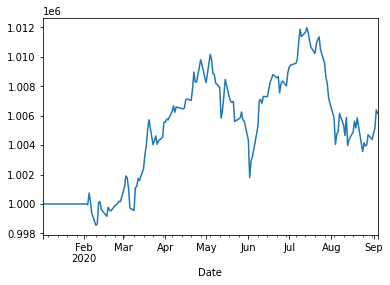

In [67]:
portfit.plot()

In [68]:
portfit[len(portfit) - 1] - 1000000

6155.565874511725

In [69]:
benchmark_price_test = yf.download('^GSPC', '2019-12-31', '2020-09-05')
                               
benchmark_ret_test = benchmark_price_test["Adj Close"].pct_change()

[*********************100%***********************]  1 of 1 completed


In [70]:
benchmark_ret_test = benchmark_ret_test.dropna()

In [71]:
x_1 = np.array(benchmark_ret_test[1:])
y_1 = np.array(portfit.pct_change()[1:])

In [72]:
slope, intercept, r_value, p_value, std_err = stats.linregress(x_1, y_1)
print("slope: %f    intercept: %f" % (slope, intercept))

slope: 0.001346    intercept: 0.000035


In [73]:
Max_week = portfit['2020-01-02':].resample('W').max()
Min_week = portfit['2020-01-02':].resample('W').min()
Max_drowdans_week =((Min_week - Max_week) / Max_week).min()
print(Max_drowdans_week)

-0.003295073314623164


In [74]:
portfit.index = portfit.index.to_timestamp()

In [75]:
portfit.calc_stats().display()

Stats for None from 2020-01-02 00:00:00 - 2020-09-04 00:00:00
Annual risk-free rate considered: 0.00%
Summary:
Total Return      Sharpe  CAGR    Max Drawdown
--------------  --------  ------  --------------
0.62%                0.8  0.92%   -0.83%

Annualized Returns:
mtd    3m     6m     ytd    1y    3y    5y    10y    incep.
-----  -----  -----  -----  ----  ----  ----  -----  --------
0.18%  0.29%  0.44%  0.62%  -     -     -     -      0.92%

Periodic:
        daily    monthly    yearly
------  -------  ---------  --------
sharpe  0.80     0.87       -
mean    0.91%    0.93%      -
vol     1.14%    1.06%      -
skew    -0.42    0.14       -
kurt    1.25     -1.50      -
best    0.19%    0.54%      -
worst   -0.25%   -0.29%     -

Drawdowns:
max     avg       # days
------  ------  --------
-0.83%  -0.22%     15.75

Misc:
---------------  ------
avg. up month    0.27%
avg. down month  -0.25%
up year %        -
12m up %         -
---------------  ------


In [76]:
#Rachev

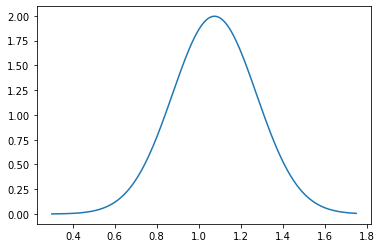

In [77]:
import scipy.stats as stats

x = np.linspace(0.3, 1.75, 1000)
plt.plot(x, stats.norm.pdf(x, 1.075, 0.2))

In [78]:
def calculate_ES(returns, alpha):
    
    scaling_const = 10.0 / returns.std()

    dist = 'Normal'
    am = arch_model(scaling_const * returns,
                    mean='ARX', lags=1, # mean = Constant, ARX, HARX + the number of lags
                    vol='Garch', p=1, o=1, q=1, # vol = Garch, EGARCH, HARCH + the number of lags
                    dist=dist) # dist = Normal, t, skewstudent, ged

    res = am.fit(update_freq=0, disp='off')

    forecasts = res.forecast(horizon=1)

    cond_mean = float(forecasts.mean.iloc[-1])
    cond_var = float(forecasts.variance.iloc[-1])

    if dist == 'Normal':
        q = am.distribution.ppf(alpha)
    elif dist == 't' or dist == 'ged':
        q = am.distribution.ppf(alpha, res.params[-1:])
    elif dist == 'skewstudent':
        q = am.distribution.ppf(alpha, res.params[-2:])

    return_garch_forecast = cond_mean / scaling_const
    ES_forecast = alpha**(-1) * stats.norm.pdf(stats.norm.ppf(alpha))*cond_var - cond_mean
    #  (cond_mean + np.sqrt(cond_var) * q) / scaling_const
    # alpha**-1 * norm.pdf(norm.ppf(alpha))*sig_h - mu_h
    return ES_forecast


def calc_ES(r, ES_fun, L_history=250, level=0.05):
    ES = np.full(r.size, np.nan)
    
    for i in range(L_history, len(r)):
        history = r[i - L_history: i]
        ES[i] = ES_fun(history, level)
        
    return pd.Series(data=ES, index=r.index, name=ES_fun.__name__)


ES_5 = calc_ES(res_new, calculate_ES, L_history=250, level=0.05)
ES_10 = calc_ES(-res_new, calculate_ES, L_history=250, level=0.10)

/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


In [79]:
ES_5=ES_5.dropna()
ES_10=ES_10.dropna()

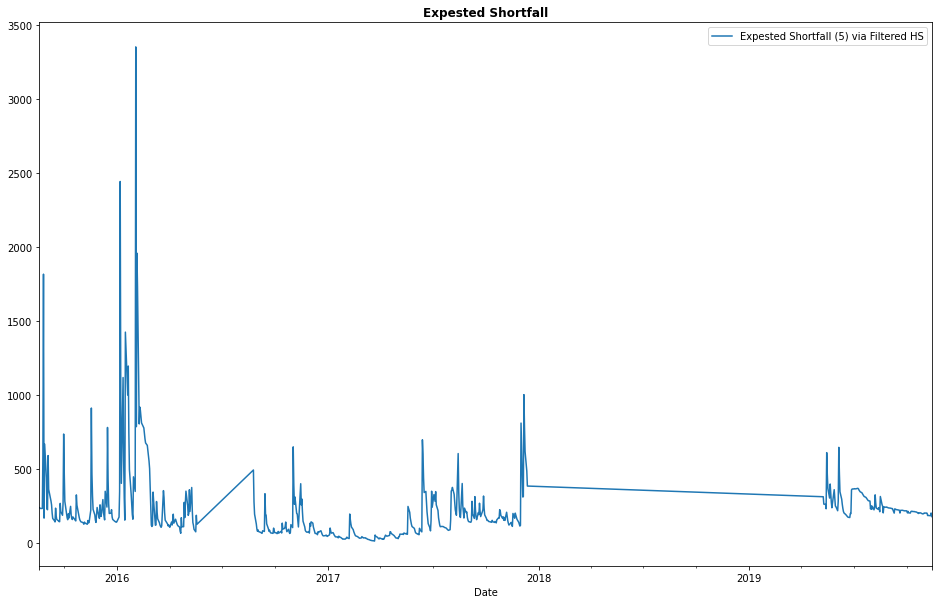

In [80]:
fig = plt.figure(figsize=(16, 10))

# ret_prt_true.plot()

ES_5.plot()

plt.title("Expested Shortfall", weight="bold")

plt.legend(['Expested Shortfall (5) via Filtered HS'])

plt.show()

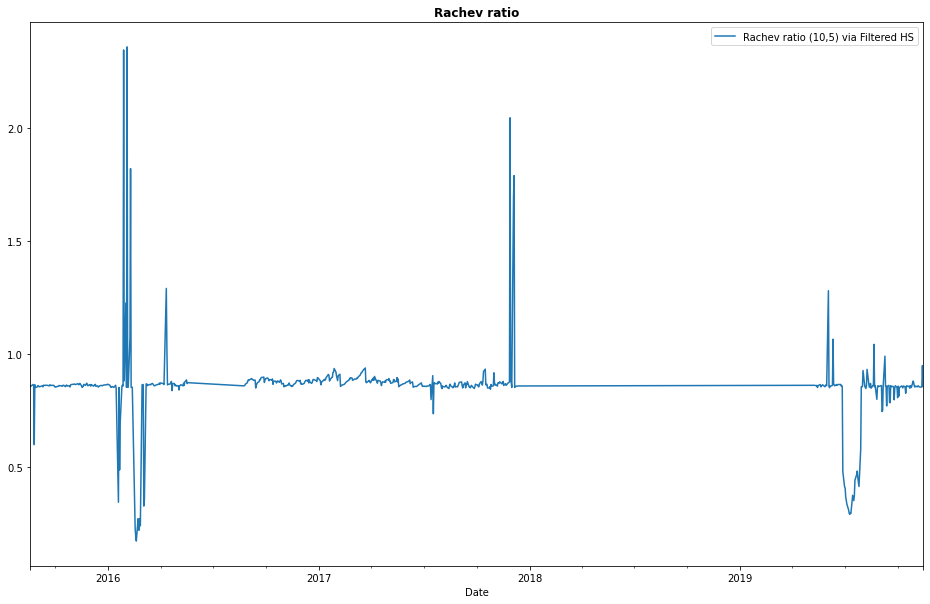

In [81]:
fig = plt.figure(figsize=(16, 10))

# ret_prt_true.plot()

(ES_10/ES_5).plot()

plt.title("Rachev ratio", weight="bold")

plt.legend(['Rachev ratio (10,5) via Filtered HS'])

plt.show()